In [49]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [50]:
data = pd.read_csv('data/train.csv')
data = data.fillna(0)
print(data.head())


         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

In [51]:
# Encode the data
from sklearn.preprocessing import LabelEncoder

df_encoded = data.copy()
label_encoders = {}

for col in df_encoded.select_dtypes(include='object'):
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

# Normalise the data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns.drop(['id', 'diagnosis'])
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])


Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4309 - loss: 0.7970 - val_accuracy: 0.8070 - val_loss: 0.5483
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7980 - loss: 0.5330 - val_accuracy: 0.9474 - val_loss: 0.3724
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9316 - loss: 0.3911 - val_accuracy: 0.9649 - val_loss: 0.2710
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9348 - loss: 0.3094 - val_accuracy: 0.9649 - val_loss: 0.2060
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9415 - loss: 0.2289 - val_accuracy: 0.9649 - val_loss: 0.1668
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9316 - loss: 0.2161 - val_accuracy: 0.9474 - val_loss: 0.1432
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9521 - loss: 0.1654 - val_accuracy: 0.9474 - val_loss: 0.1272
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9592 - loss: 0.1484 - val_accuracy: 0.9649 - val_loss

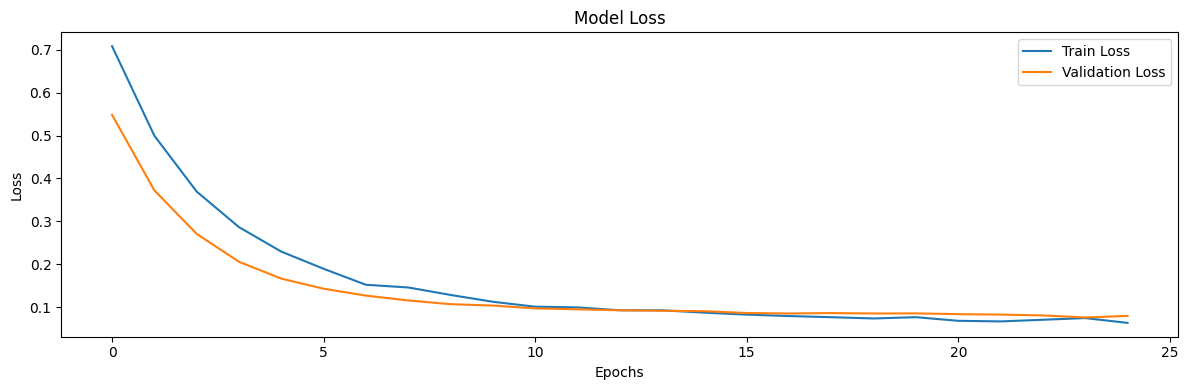

In [52]:
# Split the data into features and target
X = df_encoded.drop(columns=['diagnosis','id'])
y= df_encoded['diagnosis']

model = tf.keras.Sequential([
    tf.keras.Input(shape=(X.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping( min_delta=0.001, patience=20, restore_best_weights=True)

history = model.fit(X, y, epochs=25, batch_size=32, validation_split=0.1,callbacks=[early_stop])
# Plotting the training history
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model.predict(X)

# Reverse label encoding for y
y_original = label_encoders['diagnosis'].inverse_transform(y)
# Reverse label encoding for y_pred
y_pred_original = label_encoders['diagnosis'].inverse_transform(np.round(y_pred).astype(int)) #Our model is exporting probabilites. Next model will feature RandomForestClassifier

#Accuracy score
print(f"Acurracy score: {accuracy_score(y_original, y_pred_original) *100:.2f}%")

## Classification report (includes precision, recall, f1-score)
print("Classification Report:\n")
print(classification_report(y_original, y_pred_original))

# Confusion matrix
print("Confusion Matrix:\n")
print(confusion_matrix(y_original, y_pred_original))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acurracy score: 98.24%
Classification Report:

              precision    recall  f1-score   support

           B       0.99      0.99      0.99       357
           M       0.98      0.98      0.98       212

    accuracy                           0.98       569
   macro avg       0.98      0.98      0.98       569
weighted avg       0.98      0.98      0.98       569

Confusion Matrix:

[[352   5]
 [  5 207]]


/Users/andreas/Desktop/ml-experiments/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
model.save('models/nn_model.h5')